**Fuente**

Deep Learning for time series prediction: Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) by Fernando Carazo and Joaquín Amat Rodrigo, available under the Attribution-NonCommercial-ShareAlike 4.0 International license at https://www.cienciadedatos.net/documentos/py54-forecasting-con-deep-learning.html

bajo la licencia:
https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en#ref-same-license


La complejidad de un problema de series temporales suele definirse por tres factores clave:
- primero, decidir qué serie o series temporales utilizar para entrenar el modelo;

- segundo, determinar qué o cuántas series temporales se van a predecir;
-tercero, definir el número de pasos hacia el futuro que se desean predecir.

Las redes neuronales recurrentes, gracias a su amplia variedad de arquitecturas, permiten modelar los siguientes escenarios:

- Modelar una sola serie y predecir esa misma serie (serie única, salida única)

 Este tipo de problema implica modelar una serie temporal utilizando solo su pasado. Es un problema típico autorregresivo.
Ejemplo: Predecir la temperatura diaria en función de la temperatura de los últimos días.

- Modelar una sola serie utilizando múltiples series (multi-serie, salida única)

Descripción: Estos son problemas en los que se utilizan múltiples series temporales para predecir una sola serie. Cada serie puede representar una entidad o variable diferente, pero la variable de salida es solo una de las series.
Ejemplo: Predecir la temperatura diaria en función de múltiples series como: temperatura, humedad y presión atmosférica.

- Modelar múltiples series utilizando múltiples series (multi-serie, salidas múltiples)
Descripción: Estos problemas consisten en modelar y predecir valores futuros de varias series temporales al mismo tiempo.
Ejemplo: Predecir valores de acciones para varias acciones en función de datos históricos de acciones, precios de energía y precios de materias primas.

En todos estos escenarios, la predicción puede hacerse mediante predicción de un solo paso (un paso hacia el futuro) o predicción de varios pasos (varios pasos hacia el futuro). En el primer caso, el modelo solo predice un valor único, mientras que en el segundo, el modelo predice múltiples valores hacia el futuro.

En algunas situaciones, puede ser difícil definir y crear la arquitectura de Aprendizaje Profundo adecuada para abordar un problema específico. La biblioteca skforecast proporciona funcionalidades que permiten determinar la arquitectura de Tensorflow adecuada para cada problema, simplificando y acelerando el proceso de modelado para una amplia variedad de problemas.


In [ ]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.0/815.0 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset

import warnings
warnings.filterwarnings('once')
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"


os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        import tensorflow
    elif keras.backend.backend() == "torch":
        import torch
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

import skforecast
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

import warnings
warnings.filterwarnings('once')



In [ ]:
air_quality = fetch_dataset(name="air_quality_valencia_no_missing")
air_quality.head()

air_quality_valencia_no_missing
-------------------------------
Hourly measures of several air chemical pollutant at Valencia city (Avd.
Francia) from 2019-01-01 to 20213-12-31. Including the following variables:
pm2.5 (µg/m³), CO (mg/m³), NO (µg/m³), NO2 (µg/m³), PM10 (µg/m³), NOx (µg/m³),
O3 (µg/m³), Veloc. (m/s), Direc. (degrees), SO2 (µg/m³). Missing values have
been imputed using linear interpolation.
Red de Vigilancia y Control de la Contaminación Atmosférica, 46250047-València -
Av. França, https://mediambient.gva.es/es/web/calidad-ambiental/datos-
historicos.
Shape of the dataset: (43824, 10)


,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0
2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0
2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0


In [ ]:
print(f"Index: {air_quality.index.dtype}")
print(f"Frequency: {air_quality.index.freq}")


Index: datetime64[ns]
Frequency: <Hour>


In [ ]:
air_quality = air_quality.loc[:'2021-12-31 23:00:00', :].copy()
end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Dates train      : {air_quality_train.index.min()} --- "
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Dates validation : {air_quality_val.index.min()} --- "
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Dates test       : {air_quality_test.index.min()} --- "
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Dates train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Dates validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Dates test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


In [ ]:
air_quality_val.tail()

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2021-09-30 19:00:00,3.0,0.100000,2.0,9.0,13.0,11.0,78.0,0.9,61.0,9.0
2021-09-30 20:00:00,4.0,0.100000,2.0,9.0,14.0,11.0,76.0,0.7,47.0,10.0
2021-09-30 21:00:00,4.0,0.109091,2.0,10.0,14.0,13.0,63.0,0.7,37.0,9.0
2021-09-30 22:00:00,5.0,0.118182,2.0,12.0,11.0,15.0,60.0,0.3,38.0,8.0
2021-09-30 23:00:00,5.0,0.127273,2.0,12.0,14.0,15.0,56.0,0.3,17.0,10.0


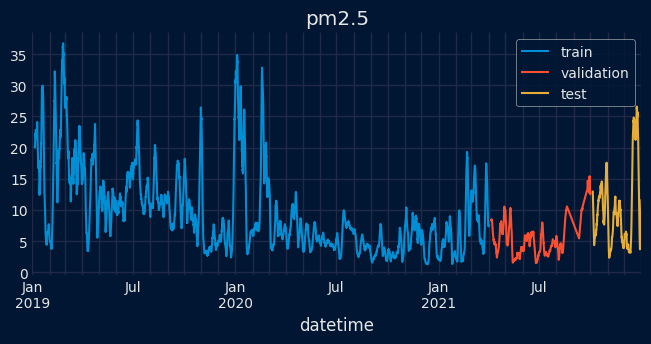

In [ ]:
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
air_quality_train["pm2.5"].rolling(100).mean().plot(ax=ax, label="train")
air_quality_val["pm2.5"].rolling(100).mean().plot(ax=ax, label="validation")
air_quality_test["pm2.5"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("pm2.5")
ax.legend()

# Modelar una sola serie y predecir esa misma serie (serie única, salida única)

## Sinlge output (una predicción)

In [ ]:
series = ["o3"]  # Series used as predictors
levels = ["o3"]  # Target serie to predict
lags = 32        # Past time steps to be used to predict the target
steps = 1        # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)
model.summary()


keras version: 3.8.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,      # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)

forecaster

/usr/local/lib/python3.11/dist-packages/skforecast/deep_learning/_forecaster_rnn.py:244: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.11/dist-packages/skforecast/deep_learning/_forecaster_rnn.py:279: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



ForecasterRnn 
Regressor: <Functional name=functional_12, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_12', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_12'}, 'registered_name': None, 'name': 'input_layer_12', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': Fal

In [ ]:
forecaster.fit(data_train)


Epoch 1/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0154 - val_loss: 0.0058
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0056 - val_loss: 0.0066
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 6/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0055 - val_loss: 0.0075
Epoch 7/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 8/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 9/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 10/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0054 - val_loss: 0.0071


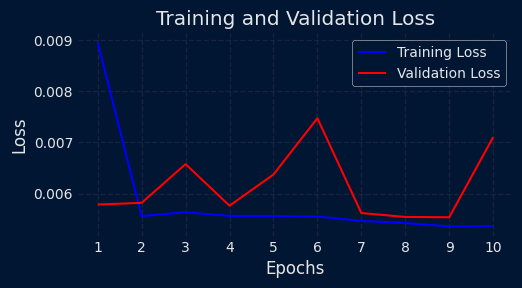

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)


In [ ]:
predictions = forecaster.predict()
predictions


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



,level,pred
2021-04-01,o3,43.962254


Para obtener una estimación robusta de la capacidad predictiva del modelo, se realiza un proceso de backtesting. El proceso de backtesting consiste en generar una predicción para cada observación en el conjunto de prueba, siguiendo el mismo procedimiento que se seguiría si el modelo estuviera en producción, y finalmente comparar el valor predicho con el valor real.

In [ ]:
# Backtesting with test data
# ==============================================================================
cv = TimeSeriesFold(
    steps=forecaster.max_step,
    initial_train_size=len(data.loc[:end_validation, :]), # Training + Validation Data
    refit=False,
)
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    levels=forecaster.levels,
    cv=cv,
    metric="mean_absolute_error",
    verbose=False, # Set to True for detailed information
)

Epoch 1/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 2/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 3/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0053 - val_loss: 0.0065
Epoch 4/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 5/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 6/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0054 - val_loss: 0.0072


  0%|          | 0/2208 [00:00<?, ?it/s]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.1

In [ ]:
predictions


,level,pred
2021-10-01 00:00:00,o3,49.947098
2021-10-01 01:00:00,o3,54.893963
2021-10-01 02:00:00,o3,58.447323
2021-10-01 03:00:00,o3,58.361485
2021-10-01 04:00:00,o3,48.559898
...,...,...
2021-12-31 19:00:00,o3,14.492241
2021-12-31 20:00:00,o3,13.332606
2021-12-31 21:00:00,o3,14.595214
2021-12-31 22:00:00,o3,14.354239


In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "colab"

In [ ]:


fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['o3'], name="test", mode="lines")
trace2 = go.Scatter(
    x=predictions.index,
    y=predictions.loc[predictions["level"] == "o3", "pred"],
    name="predictions", mode="lines"
)
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Prediction vs real values in the test set",
    xaxis_title="Date time",
    yaxis_title="O3",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.05, xanchor="left", x=0)
)
fig.show()


In [ ]:
metrics


,levels,mean_absolute_error
0,o3,6.598834


In [ ]:
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 12.10 %


## Predicción multistep

El siguiente caso es predecir los próximos 5 valores de O3 utilizando solo sus datos históricos. Por lo tanto, se trata de un escenario en el que se modelan múltiples pasos futuros de una sola serie temporal utilizando solo sus valores pasados.
Se utilizará una arquitectura similar a la anterior, pero con un mayor número de neuronas en la capa LSTM y en la primera capa densa. Esto permitirá que el modelo tenga mayor flexibilidad para modelar la serie temporal.

In [ ]:
series = ["o3"]  # Series used as predictors
levels = ["o3"]  # Target serie to predict
lags = 32        # Past time steps to be used to predict the target
steps = 5        # Future time steps to be predicted

model = create_and_compile_model(
    series=data_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=50,
    dense_units=32,
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.8.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,197 (47.64 KB)

 Trainable params: 12,197 (47.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,      # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)

forecaster

/usr/local/lib/python3.11/dist-packages/skforecast/deep_learning/_forecaster_rnn.py:244: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.11/dist-packages/skforecast/deep_learning/_forecaster_rnn.py:279: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



ForecasterRnn 
Regressor: <Functional name=functional_13, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_13', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_13'}, 'registered_name': None, 'name': 'input_layer_13', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwar

In [ ]:
forecaster.fit(data_train)


Epoch 1/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0277 - val_loss: 0.0169
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 6/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0116 - val_loss: 0.0117
Epoch 7/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 8/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0112 - val_loss: 0.0125
Epoch 9/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0112 - val_loss: 0.0123
Epoch 10/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0115 - val_loss: 0.0119


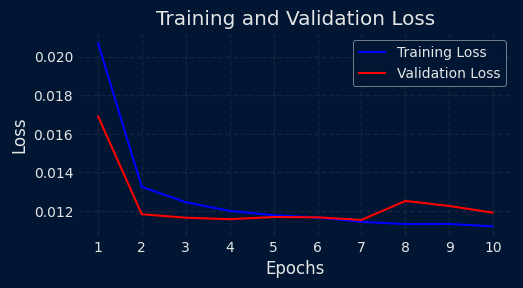

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)


la predicción será de menor calidad que en el caso anterior, ya que el error observado en las diferentes épocas es mayor. Esto tiene una explicación simple, y es que el modelo tiene que predecir 5 valores en lugar de 1. Por lo tanto, el error de validación es mayor ya que se está calculando la pérdida de 5 valores en lugar de 1.

In [ ]:
predictions = forecaster.predict()
predictions


,level,pred
2021-04-01 00:00:00,o3,46.536388
2021-04-01 01:00:00,o3,43.569019
2021-04-01 02:00:00,o3,39.763615
2021-04-01 03:00:00,o3,36.489872
2021-04-01 04:00:00,o3,35.531082


Se pueden predecir pasos específicos que estén en el intervalo de los 5 pasos.

In [ ]:
# Specific step predictions
# ==============================================================================
predictions = forecaster.predict(steps=[1, 3])
predictions

,level,pred
2021-04-01 00:00:00,o3,46.536388
2021-04-01 02:00:00,o3,39.763615


In [ ]:
cv = TimeSeriesFold(
    steps=forecaster.max_step,
    initial_train_size=len(data.loc[:end_validation, :]),
    refit=False,
)

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    levels=forecaster.levels,
    cv=cv,
    metric="mean_absolute_error",
    verbose=False,
)

Epoch 1/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 2/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 3/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 4/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 5/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 6/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 7/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0106 - val_loss: 0.0131
Epoch 8/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0109 - val_loss: 0.0111
Epoch 9/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 10/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 0.0105 - val_loss: 0.0108


  0%|          | 0/442 [00:00<?, ?it/s]

In [ ]:
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['o3'], name="test", mode="lines")
trace2 = go.Scatter(
    x=predictions.index,
    y=predictions.loc[predictions["level"] == "o3", "pred"],
    name="predictions", mode="lines"
)
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Prediction vs real values in the test set",
    xaxis_title="Date time",
    yaxis_title="O3",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.05, xanchor="left", x=0)
)
fig.show()

In [ ]:
metrics


,levels,mean_absolute_error
0,o3,9.353122


In [ ]:
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")


Serie mean: 54.52
Relative error (mae): 17.16 %


# Modelar una sola serie utilizando múltiples series (multi-serie, salida única)

En este caso, se predecirá la misma serie, pero utilizando múltiples series temporales como predictores. Por lo tanto, se trata de un escenario en el que se utilizan valores pasados de múltiples series temporales para predecir una sola serie temporal.

Estos tipos de enfoques son muy útiles cuando se dispone de múltiples
series temporales relacionadas entre sí. Por ejemplo, en el caso de la predicción de temperatura, se pueden utilizar múltiples series temporales como la humedad, la presión atmosférica, la velocidad del viento, etc.

En este tipo de problemas, la arquitectura de la red neuronal es más compleja, se necesita una capa densa recurrente adicional para procesar las múltiples series de entrada. Además, se agrega otra capa densa oculta para procesar la salida de la capa recurrente. Como se puede ver, crear el modelo utilizando skforecast es muy simple, simplemente se pasa una lista de enteros a los argumentos recurrent_units y dense_units para crear múltiples capas recurrentes y densas.

In [ ]:
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.','so2']
levels = ["o3"]
lags = 32
steps = 5

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.8.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 32, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,109 (312.93 KB)

 Trainable params: 80,109 (312.93 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 4,
        "batch_size": 128,
        "series_val": data_val,
    },
)
forecaster

ForecasterRnn 
Regressor: <Functional name=functional_14, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_14', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_14'}, 'registered_name': None, 'name': 'input_layer_14', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': False, 'go_backwar

In [ ]:
forecaster.fit(data_train)


Epoch 1/4
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - loss: 0.7790 - val_loss: 0.0289
Epoch 2/4
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 0.0163 - val_loss: 0.0139
Epoch 3/4
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - loss: 0.0115 - val_loss: 0.0141
Epoch 4/4
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - loss: 0.0109 - val_loss: 0.0127


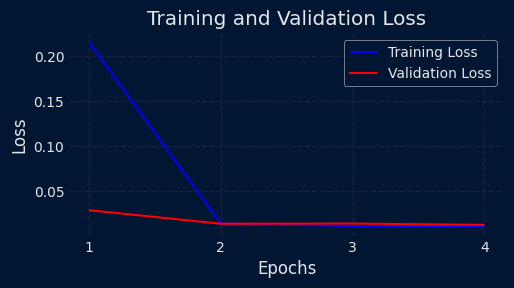

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)


In [ ]:
predictions = forecaster.predict()
predictions


,level,pred
2021-04-01 00:00:00,o3,45.593166
2021-04-01 01:00:00,o3,42.650246
2021-04-01 02:00:00,o3,39.131195
2021-04-01 03:00:00,o3,35.922073
2021-04-01 04:00:00,o3,34.118126


In [ ]:
cv = TimeSeriesFold(
        steps=forecaster.max_step,
        initial_train_size=len(data.loc[:end_validation, :]),
        refit=False,
)
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    levels=forecaster.levels,
    cv=cv,
    metric="mean_absolute_error",
    verbose=False,
)

Epoch 1/4
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - loss: 0.0110 - val_loss: 0.0135
Epoch 2/4
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - loss: 0.0106 - val_loss: 0.0107
Epoch 3/4
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - loss: 0.0102 - val_loss: 0.0112
Epoch 4/4
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - loss: 0.0101 - val_loss: 0.0115


  0%|          | 0/442 [00:00<?, ?it/s]

In [ ]:
metrics


,levels,mean_absolute_error
0,o3,9.910818


In [ ]:
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 18.18 %


In [ ]:
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['o3'], name="test", mode="lines")
trace2 = go.Scatter(
    x=predictions.index,
    y=predictions.loc[predictions["level"] == "o3", "pred"],
    name="predictions", mode="lines"
)
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Prediction vs real values in the test set",
    xaxis_title="Date time",
    yaxis_title="O3",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.05, xanchor="left", x=0)
)
fig.show()

Cuando se utilizan múltiples series temporales como predictores, se esperaría que el modelo pueda predecir la serie objetivo mejor. Sin embargo, en este caso, las predicciones son peores que en el caso anterior donde solo se utilizó una serie temporal como predictor. Esto puede deberse a que las series temporales utilizadas como predictores no están relacionadas con la serie objetivo. Por lo tanto, el modelo no puede aprender ninguna relación entre ellas.

## Multi-output

En el siguiente y último escenario, se predicen múltiples series temporales utilizando múltiples series temporales como predictores. Por lo tanto, se trata de un escenario en el que se modelan múltiples series simultáneamente utilizando un solo modelo. Esto tiene una aplicación especial en muchos escenarios reales, como la predicción de valores de acciones para varias empresas en función de la historia de las acciones, el precio de la energía y las materias primas. O el caso de pronosticar múltiples productos en una tienda en línea, en función de las ventas de otros productos, el precio de los productos, etc."

In [ ]:
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2']
levels = ['pm2.5', 'co', 'no', "o3"]  # Features to predict. It can be all the series or less
lags   = 32
steps  = 5

data       = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val   = air_quality_val[series].copy()
data_test  = air_quality_test[series].copy()

model = create_and_compile_model(
    series          = data_train,
    levels          = levels,
    lags            = lags,
    steps           = steps,
    recurrent_layer = "LSTM",
    recurrent_units = [100, 50],
    dense_units     = [64, 32],
    optimizer       = Adam(learning_rate=0.01),
    loss            = MeanSquaredError()
)
model.summary()

keras version: 3.8.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 32, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 5, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,604 (314.86 KB)

 Trainable params: 80,604 (314.86 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
forecaster = ForecasterRnn(
    regressor          = model,
    levels             = levels,
    steps              = steps,
    lags               = lags,
    transformer_series = MinMaxScaler(),
    fit_kwargs         = {
                            "epochs": 10,
                            "batch_size": 1024,
                            "callbacks": [
                                EarlyStopping(monitor="val_loss", patience=3)
                            ],
                            "series_val": data_val,
                        },
)
forecaster

ForecasterRnn 
Regressor: <Functional name=functional_15, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['pm2.5', 'co', 'no', 'o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_15', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_15'}, 'registered_name': None, 'name': 'input_layer_15', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_18', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state

In [ ]:
forecaster.fit(data_train)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 549ms/step - loss: 0.0315 - val_loss: 0.0198
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 601ms/step - loss: 0.0124 - val_loss: 0.0172
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 591ms/step - loss: 0.0093 - val_loss: 0.0152
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 602ms/step - loss: 0.0093 - val_loss: 0.0138
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 562ms/step - loss: 0.0070 - val_loss: 0.0120
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - loss: 0.0060 - val_loss: 0.0106
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 534ms/step - loss: 0.0053 - val_loss: 0.0112
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 571ms/step - loss: 0.0051 - val_loss: 0.0097
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 526ms/step - loss: 0.0047 - val_loss: 0.0096
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 605ms/step - loss: 0.0045 - val_loss: 0.0096


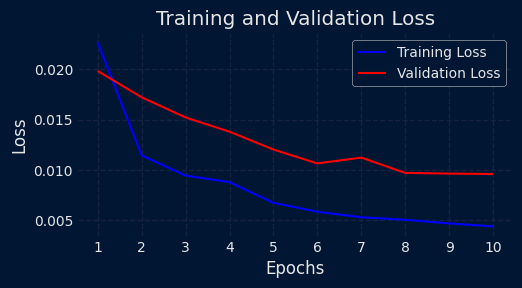

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)


In [ ]:
predictions = forecaster.predict()
predictions

,level,pred
2021-04-01 00:00:00,co,0.114947
2021-04-01 00:00:00,no,0.731215
2021-04-01 00:00:00,o3,42.938866
2021-04-01 00:00:00,pm2.5,12.471410
2021-04-01 01:00:00,co,0.112590
2021-04-01 01:00:00,no,3.946778
2021-04-01 01:00:00,o3,37.729816
2021-04-01 01:00:00,pm2.5,12.704990
2021-04-01 02:00:00,co,0.118093
2021-04-01 02:00:00,no,2.899956


In [ ]:
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),
         refit              = False
     )

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster =forecaster,
    series     = data,
    cv         = cv,
    levels     = forecaster.levels,
    metric     = "mean_absolute_error",
    verbose    = False
)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 519ms/step - loss: 0.0045 - val_loss: 0.0093
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - loss: 0.0039 - val_loss: 0.0088
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 551ms/step - loss: 0.0038 - val_loss: 0.0086
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 530ms/step - loss: 0.0038 - val_loss: 0.0089
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 542ms/step - loss: 0.0037 - val_loss: 0.0086
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - loss: 0.0036 - val_loss: 0.0083
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step - loss: 0.0035 - val_loss: 0.0086
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step - loss: 0.0036 - val_loss: 0.0082
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 537ms/step - loss: 0.0035 - val_loss: 0.0079
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 602ms/step - loss: 0.0035 - val_loss: 0.0075


  0%|          | 0/442 [00:00<?, ?it/s]

In [ ]:
metrics


,levels,mean_absolute_error
0,pm2.5,3.763609
1,co,0.031192
2,no,3.056758
3,o3,10.631182
4,average,4.370685
5,weighted_average,4.370685
6,pooling,4.370685


In [ ]:
for i, level in enumerate(levels):
    fig = go.Figure()
    trace1 = go.Scatter(x=data_test.index, y=data_test[level], name="test", mode="lines")
    trace2 = go.Scatter(
        x=predictions.loc[predictions["level"] == level, "pred"].index,
        y=predictions.loc[predictions["level"] == level, "pred"],
        name="predictions", mode="lines"
    )
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Prediction vs real values in the test set",
        xaxis_title="Date time",
        yaxis_title=level,
        width=800,
        height=300,
        margin=dict(l=20, r=20, t=35, b=20),
        legend=dict(orientation="h", yanchor="top", y=1.05, xanchor="left", x=0)
    )
    fig.show()


Los resultados del backtesting muestran que el modelo es capaz de capturar el patrón de las series temporales pm2.5 y O3, pero no el de las series CO y NO. Esto puede deberse a que las primeras tienen un comportamiento más autorregresivo, mientras que los valores futuros de las últimas no parecen depender de los valores pasados.
Se observa que el error de backtesting para la serie O3 es mayor que el obtenido cuando solo se modelaba esa serie. Esto puede deberse a que el modelo está tratando de modelar múltiples series temporales al mismo tiempo, lo que hace que el problema sea más complejo.